In [2]:
import warnings
warnings.filterwarnings("ignore", "in-band")

In [3]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt

import zuko

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

In [4]:
import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
#from river.data.dataset import #DatasetStrainFD, #DatasetStrainFDFromPreCalSVDWF
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D

In [5]:
import sealgw

# data gen

In [6]:
Nsample = 20
Ntest = 1
injection_parameters_all = generate_BNS_injection_parameters(
        Nsample,
        a_max=0.1,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = True)

injection_parameters_test = generate_BNS_injection_parameters(
        Ntest,
        a_max=0.1,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = True)

In [7]:
f2=50
f1=20

m=1.4
duration = sealgw.simulation.generating_data.tau_of_f(f1,m1=m, m2=m)-sealgw.simulation.generating_data.tau_of_f(f2,m1=m, m2=m)
length = duration*(f2-f1)

print(duration, length)

143.77568550602984 4313.270565180896


In [8]:
#sealgw.simulation.generating_data.f_of_tau(100,m1=1.4, m2=1.4)

In [9]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

In [10]:
data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

data_generator_test = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

05:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
05:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.
Using bilby_default PSDs to generate data.


In [12]:
ifos = data_generator.ifos

In [19]:
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=0)

In [20]:
det = ifos[0]

In [22]:
det.name

'H1'

In [21]:
det.frequency_domain_strain[data_generator.frequency_mask]

array([-2.04730141e-23-1.63301037e-23j,  1.00053268e-23-2.15364464e-23j,
       -1.09223791e-23-3.21498654e-23j, ...,
        5.99867386e-24-1.46820565e-23j,  3.88188570e-24+2.33141300e-23j,
        0.00000000e+00+0.00000000e+00j])

In [148]:
f = data_generator.frequency_array_masked


In [85]:
f = data_generator.frequency_array_masked

data_generator.generate_waveforms(injection_parameters_all)
data_generator_test.generate_waveforms(injection_parameters_test)

In [86]:
rand_phase = np.random.uniform(0,2*np.pi, Nsample*2)
rand_phase_test = np.random.uniform(0,2*np.pi, Ntest*2)

In [109]:
hp = np.array(data_generator.waveforms['waveform_polarizations']['plus']['amplitude']) *\
    np.exp(1j* np.array(data_generator.waveforms['waveform_polarizations']['plus']['phase']))

hc = np.array(data_generator.waveforms['waveform_polarizations']['cross']['amplitude']) *\
    np.exp(1j* np.array(data_generator.waveforms['waveform_polarizations']['cross']['phase']))

h_train = np.vstack([hp,hc])
#h_train = h_train * np.repeat(np.exp(1j*rand_phase), h_train.shape[1]).reshape(h_train.shape)
#h_train = hp

hp_test = np.array(data_generator_test.waveforms['waveform_polarizations']['plus']['amplitude']) *\
    np.exp(1j* np.array(data_generator_test.waveforms['waveform_polarizations']['plus']['phase']))

hc_test = np.array(data_generator_test.waveforms['waveform_polarizations']['cross']['amplitude']) *\
    np.exp(1j* np.array(data_generator_test.waveforms['waveform_polarizations']['cross']['phase']))

h_tests = np.vstack([hp_test,hc_test])
#h_tests = h_tests * np.repeat(np.exp(1j*rand_phase_test), h_tests.shape[1]).reshape(h_tests.shape)


In [116]:
V[:, :512].shape

(31169, 512)

In [115]:
hp.shape

(20, 31169)

In [118]:
np.dot(hp, V[:, :512]).shape

(20, 512)

In [202]:

h_train = np.vstack([np.array(data_generator.waveforms['waveform_polarizations']['plus']['amplitude']),
                     np.array(data_generator.waveforms['waveform_polarizations']['cross']['amplitude'])])

h_tests = np.vstack([np.array(data_generator_test.waveforms['waveform_polarizations']['plus']['amplitude']),
                     np.array(data_generator_test.waveforms['waveform_polarizations']['cross']['amplitude'])])

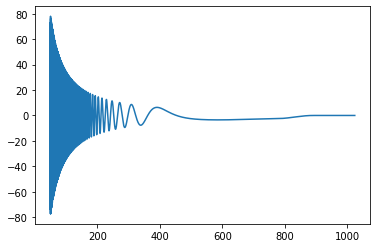

In [59]:
plt.plot(f,np.real(h_train[4]))
#plt.xlim(20, 25)

In [88]:
det = data_generator.ifos[0]

In [89]:
psd = det.power_spectral_density_array[data_generator.frequency_mask]

In [90]:
hh = hp[0] * 1e-23

In [91]:
np.sum( np.real (hh*hh.conj() / psd ))

21182791.86574785

In [92]:
hh

array([ 2.46827487e-22+5.01013888e-22j, -5.56375787e-22+4.38320470e-23j,
        1.63344278e-22-5.33227759e-22j, ...,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j])

In [107]:
hh_compressed = (hh / psd**0.5) @ V[:, :512]
hh_decomp = hh_compressed @ Vh[:512]

psd_compressed = psd @ V[:, :512]

In [108]:
np.real ( np.sum(hh_compressed*hh_compressed.conj() / 1 ))

21170642.34896679

In [100]:
np.sum( np.real (hh_decomp*hh_decomp.conj() / psd ))

21182604.754862312

In [40]:
f"outputs/Vh_{f_low}Hz{f_high}Hz{duration}s"

'outputs/Vh_50Hz1024Hz32s'

In [49]:
duration

251.90232332815393

# complex SVD

In [46]:
h_train.shape

(40000, 7681)

In [60]:
n=600

if 1:
    U, s, Vh = randomized_svd(h_train, n)
    V = Vh.T.conj()
else:
    U, s, Vh = scipy.linalg.svd(h_train, full_matrices=False)
    V = Vh.T.conj()
    V = V[:, :n]
    Vh = Vh[:n, :]
    

In [48]:
V.shape

(7681, 2048)

In [75]:
with open(f"outputs/Vh_{f_low}Hz{f_high}Hz{duration}s.pickle", 'wb') as f:
    pickle.dump(Vh, f)

with open(f"outputs/s_{f_low}Hz{f_high}Hz{duration}s.pickle", 'wb') as f:
    pickle.dump(s, f)

with open(f"outputs/U_{f_low}Hz{f_high}Hz{duration}s.pickle", 'wb') as f:
    pickle.dump(U, f)

In [102]:
with open(f"outputs/Vh_{f_low}Hz{f_high}Hz{duration}s.pickle", 'rb') as f:
    Vh = pickle.load(f)
    V = Vh.T.conj()

In [78]:
Vh.shape

(600, 31169)

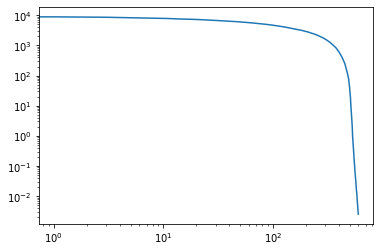

In [61]:
plt.loglog(s)

In [51]:
len(s)

2048

In [62]:
ntest=n

h_test = h_tests[99]
#h_test = h_train[1020]
h_compressed = h_test @ V[:, :ntest] #np.dot(h_test , V)
h_decomp = h_compressed @ Vh[:ntest] #np.dot(h_compressed , Vh)

In [63]:
%time h_decomp = h_compressed @ Vh[:ntest]

CPU times: user 139 ms, sys: 27.1 ms, total: 166 ms
Wall time: 5.67 ms


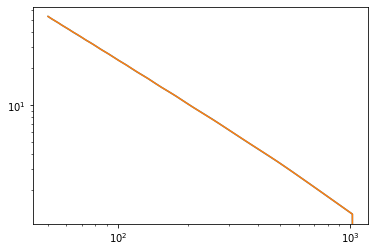

In [64]:
plt.loglog(f, abs(h_test))
plt.loglog(f, abs(h_decomp))

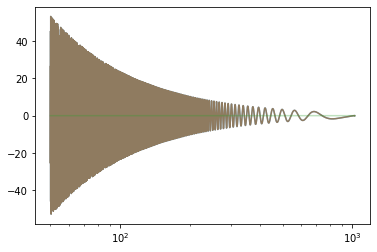

In [65]:
plt.plot(f, np.real(h_test))
plt.plot(f, np.real(h_decomp), alpha=0.5)
plt.plot(f, abs(np.real(h_test-h_decomp)),  alpha=0.3)

plt.xscale('log')

In [66]:
max(abs(np.real(h_test-h_decomp)))

0.00026747600072951627

In [67]:
mismatches = []

increment = 20
mm_lowthre = 1e-30
ntests = np.append(np.arange(increment, n, increment), n)
for ntest in ntests:
    mismatch_n = []
    for h_test in h_tests:
        h_compressed = h_test @ V[:, :ntest] #np.dot(h_test , V)
        h_decomp = h_compressed @ Vh[:ntest] #np.dot(h_compressed , Vh)
    
        norm1 = np.sqrt(np.sum(np.abs(h_test) ** 2))
        norm2 = np.sqrt(np.sum(np.abs(h_decomp) ** 2))
        inner = np.sum(h_test.conj() * h_decomp).real
        mismatch = 1 - inner / (norm1 * norm2)
        if mismatch<mm_lowthre:
            mismatch_n.append(mm_lowthre)
        else:
            mismatch_n.append(mismatch)
    mismatches.append(mismatch_n)

mismatches = np.array(mismatches)
logMM = np.log10(mismatches)

In [58]:
ntests

array([  20,   40,   60,   80,  100,  120,  140,  160,  180,  200,  220,
        240,  260,  280,  300,  320,  340,  360,  380,  400,  420,  440,
        460,  480,  500,  520,  540,  560,  580,  600,  620,  640,  660,
        680,  700,  720,  740,  760,  780,  800,  820,  840,  860,  880,
        900,  920,  940,  960,  980, 1000, 1020, 1040, 1060, 1080, 1100,
       1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320,
       1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540,
       1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760,
       1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980,
       2000, 2020, 2040, 2048])

In [59]:
np.arange(0,len(ntests),2)+1

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103])

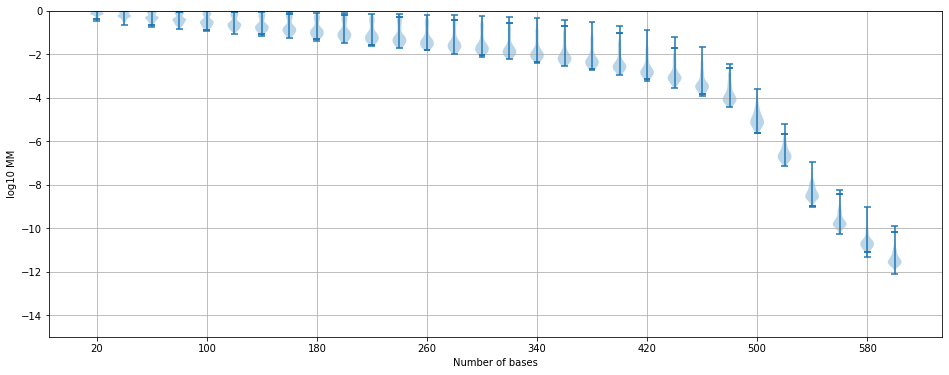

In [68]:
plt.figure(figsize=(16,6))


_ = plt.violinplot(logMM.T, quantiles=np.tile([0.01,0.99], logMM.shape[0]).reshape(2, logMM.shape[0]))

plt.ylabel('log10 MM')
plt.xlabel('Number of bases')

plt.xticks(np.arange(0,len(ntests),4)+1, labels=ntests[::4])

plt.grid()
#plt.savefig(f'outputs/mm_vs_nbasis_{f_low}Hz{f_high}Hz{duration}s.png')

#plt.xscale('log')
plt.ylim(-15,0)
plt.show()

In [69]:
import pickle

In [158]:
pp = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/train/batch0/precalwf_bns_50Hz1024Hz32s_lowspin_0.h5'
testwfdict = load_dict_from_hdf5(pp)


In [165]:
%time testwfdict = load_dict_from_hdf5(pp)

CPU times: user 7.12 ms, sys: 2.25 ms, total: 9.37 ms
Wall time: 15.1 ms


In [125]:
testid = 0
testmode = 'plus'

h1_svd = testwfdict['waveform_polarizations'][testmode]['amplitude'][testid] * \
    np.exp(1j*testwfdict['waveform_polarizations'][testmode]['phase'][testid])

h1_reco = h1_svd @ Vh[:512]

In [130]:
testwfdict['injection_parameters'].keys()

dict_keys(['a_1', 'a_2', 'chirp_mass', 'delta_lambda_tilde', 'lambda_1', 'lambda_2', 'lambda_tilde', 'mass_1', 'mass_2', 'mass_ratio', 'phase', 'phi_12', 'phi_jl', 'theta_jn', 'tilt_1', 'tilt_2'])

In [135]:
testinjpara = {}
for key in testwfdict['injection_parameters'].keys():
    testinjpara[key] = testwfdict['injection_parameters'][key][testid]
testinjpara['luminosity_distance']=1

In [140]:
h2 = data_generator.waveform_generator.frequency_domain_strain(testinjpara)[testmode][data_generator.frequency_mask]

In [141]:
norm1 = np.sqrt(np.sum(np.abs(h1_reco) ** 2))
norm2 = np.sqrt(np.sum(np.abs(h2) ** 2))
inner = np.sum(h1_reco.conj() * h2).real
mismatch = 1 - inner / (norm1 * norm2)

In [142]:
mismatch

1.3724329914754918e-06

In [144]:
h1_reco

array([-5.16926484e-22-3.12002955e-22j,  5.37669961e-22-2.66751457e-22j,
       -5.46786664e-23+6.02173293e-22j, ...,
        4.37057848e-25-2.88510632e-25j,  4.37751922e-25-2.89358658e-25j,
        0.00000000e+00+0.00000000e+00j])

In [145]:
h2

array([-5.15750362e-22-3.12196733e-22j,  5.38732167e-22-2.69795478e-22j,
       -5.67156925e-23+5.99471848e-22j, ...,
       -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        0.00000000e+00-0.00000000e+00j])

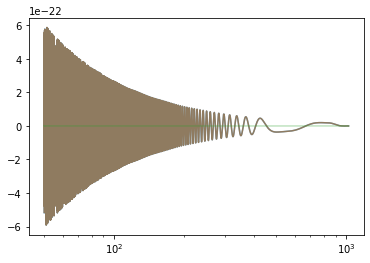

In [149]:
plt.plot(f, np.real(h1_reco))
plt.plot(f, np.real(h2), alpha=0.5)
plt.plot(f, abs(np.real(h1_reco-h2)),  alpha=0.3)

plt.xscale('log')

In [150]:
max(abs(np.real(h1_reco-h2)))

2.0370261004466988e-24

# Kernel PCA

In [30]:
h_train.shape

(60000, 2001)

In [34]:
n_components = 512
kernel = 'cosine'
n_jobs = 10
kpca = KernelPCA(n_components = n_components,
                kernel = kernel,
                n_jobs=n_jobs)

In [ ]:
kpca.fit(np.real(h_train)) #too slow

# amp + phase IPCA

In [56]:
ipca = load_model('/home/qian.hu/mlpe/river/scripts/ipca_models/realimag/IPCA_HPHC_BNSFD_10000to256_realimag_lowspin_200Mpc.pickle')

Model loaded from /home/qian.hu/mlpe/river/scripts/ipca_models/realimag/IPCA_HPHC_BNSFD_10000to256_realimag_lowspin_200Mpc.pickle


In [57]:
mode = 'plus'
A_list = data_generator.waveforms['waveform_polarizations'][mode]['amplitude']
phi_list = data_generator.waveforms['waveform_polarizations'][mode]['phase']

f = data_generator.frequency_array_masked

testid = 0
h = A_list[0] * np.exp(1j * phi_list[0])

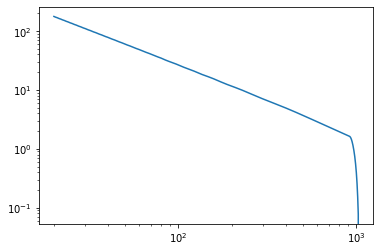

In [58]:
plt.loglog(f, abs(h))

In [74]:
wftest = np.real(h)
wfproj = ipca.project(wftest)
wfreco = np.dot(wfproj, ipca.ipca.components_)

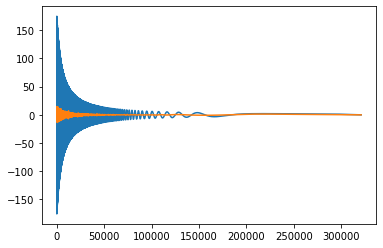

In [77]:
plt.plot(wftest)
plt.plot(wfreco)

In [79]:
ttdd = {'plus': np.array([[1,2,3,4], [1,2,4,3]]),
       'cross': np.array([[-1,-2,-3,-4], [-1,-2,-4,-3]])}

In [80]:
train_data = np.vstack([val[::] for val in ttdd.values()])

In [81]:
train_data

array([[ 1,  2,  3,  4],
       [ 1,  2,  4,  3],
       [-1, -2, -3, -4],
       [-1, -2, -4, -3]])

In [76]:
wfreco

array([-3.17753332, -2.3132672 ,  0.78248756, ...,  0.11799512,
        0.11799039,  0.        ])

In [69]:
wfproj.shape

(256,)

In [70]:
ipca.ipca.components_.shape

(256, 321281)

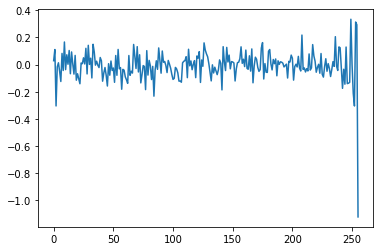

In [66]:
plt.plot(np.squeeze(ipca.ipca.transform([np.real(h)])))

In [71]:
ipca.project??

Signature: ipca.project(strain)
Docstring: <no docstring>
Source:   
    def project(self, strain):
        #pca = self.pca_dict[modename][part]
        #proj = pca.transform(strain)
        proj = np.dot(strain, self.ipca.components_.T)
        return proj
File:      ~/mlpe/river/river/models/embedding/pca.py
Type:      method


In [30]:
np.real(h).shape

(32129,)

In [31]:
32*2048

65536

In [33]:
ipca.ipca.components_.shape

(256, 321281)

In [36]:
321281 / 32129

9.999719879236826

In [38]:
strain_template_dict = data_generator.waveforms['waveform_polarizations']

In [40]:
htrain = np.array(strain_template_dict[mode]['amplitude']) * np.exp(1j* np.array(strain_template_dict[mode]['phase']))

In [43]:
htrain[0].shape

(32129,)

In [46]:
data_generator.rearrange_waveforms_for_ipca(data_generator.waveforms['waveform_polarizations'])

TypeError: string indices must be integers

In [51]:
Nsample_template = 10
Nround = 2 # actual sample of training will be Nsample_template * Nround
selection_factor = 2
snr_threshold = 8



whiten_pca = True
n_components=5
ipca_gen = embedding.pca.IPCAGeneratorFDWFRL( n_components, whiten = whiten_pca)

for i in range(Nround):
        print(f'round {i}.')
        injection_parameters_template = generate_BNS_injection_parameters(
                Nsample_template,
                a_max=0.1,
                d_min=10,
                d_max=200,
                d_power=1,
                tc_min=-0.1,
                tc_max=0.1)


        data_template_generator = DataGeneratorBilbyFD(source_type,
                detector_names, 
                duration, 
                f_low, 
                f_ref, 
                sampling_frequency, 
                waveform_approximant, 
                parameter_names,
                PSD_type=PSD_type,
                use_sealgw_detector=use_sealgw_detector,
                snr_threshold=snr_threshold)

        data_template_generator.generate_waveforms(injection_parameters_template)
        #ipca_gen.fit(data_template_generator.rearrange_waveforms_for_ipca(data_template_generator.waveforms['waveform_polarizations']))
        ipca_gen.fit(data_template_generator.waveforms['waveform_polarizations'])
        
        data_template_generator.initialize_waveforms()

20:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


round 0.
Using bilby_default PSDs to generate data.
Training IPCA for plus
Training IPCA for cross


20:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


round 1.
Using bilby_default PSDs to generate data.
Training IPCA for plus
Training IPCA for cross


In [52]:
ipca_gen.ipca.components_.shape

(5, 32129)

# archived

In [28]:
import umap
umap.UMAP?

Init signature:
umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
Docstring:     
Uniform Manifold

In [44]:
reducer = umap.UMAP(n_components=64)

In [45]:
reducer.fit(np.real(h_train))

UMAP(n_components=64, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [46]:
hcomp_umap = reducer.transform([np.real(h_train)[0]])

In [47]:
hcomp_umap

array([[-1.0803106,  2.8934221,  1.5255845,  4.872387 ,  4.5056186,
         4.5847607,  2.145204 ,  1.5614368,  2.4515207,  1.4860678,
         4.224644 ,  6.5140257,  5.3054156,  7.3725014,  7.1748347,
         7.264553 ,  5.864141 ,  5.8782744,  4.4946446,  5.341788 ,
         6.416881 ,  3.2949467,  6.347486 ,  4.5358615,  2.5753093,
         5.7293043,  3.5245786,  5.851518 ,  5.616456 ,  8.085146 ,
         6.108367 ,  8.079998 ,  4.971336 ,  4.955176 ,  4.830278 ,
         6.1674566,  7.879144 ,  7.4483037,  2.476032 ,  2.7147486,
         2.9105031,  6.202984 ,  6.7560415,  4.4920526,  3.4107203,
         1.9612877,  6.873823 ,  5.0506625,  5.7375617,  3.1032703,
         5.6988025,  6.510788 ,  1.2872987,  4.782725 ,  6.143766 ,
         5.4856334,  8.485883 ,  4.904825 ,  5.998684 ,  3.39457  ,
         4.1665654,  3.3821352,  4.9903183,  6.5854187]], dtype=float32)

In [ ]:
hreco_umap = reducer.inverse_transform(hcomp_umap)

/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/umap/umap_.py:3152: UserWarning: Inverse transform works best with low dimensional embeddings. Results may be poor, or this approach to inverse transform may fail altogether! If you need a high dimensional latent space and inverse transform operations consider using an autoencoder.
  warn(


In [ ]:
hreco_umap

In [45]:
h_train.shape

(20000, 7553)